# Modeling

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import time

from sklearn.dummy import DummyClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve, auc, make_scorer, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer


from imblearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV

import sys
sys.path.append('../src')  
import utils as util

utils OK


## Load Configuration File

In [26]:
config = util.load_config()

## Load Data

In [3]:
X_train_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_train']
y_train_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_train']

X_test_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_test']
y_test_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_test']

X_train_feng_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_train_feng']
y_train_feng_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_train_feng']

X_test_feng_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_test_feng']
y_test_feng_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['y_test_feng']


X_train = joblib.load(X_train_path)
y_train = joblib.load(y_train_path)

X_test = joblib.load(X_test_path)
y_test = joblib.load(y_test_path)

X_train_feng = joblib.load(X_train_feng_path)
y_train_feng = joblib.load(y_train_feng_path)

X_test_feng = joblib.load(X_test_feng_path)
y_test_feng = joblib.load(y_test_feng_path)

In [4]:
def plot_cm(cm, chart):

    plt.figure(figsize=(6, 5))
    plt.suptitle(f'Confusion Matrix of {chart}', y=1)

    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_initial = ['(TN)', '(FP)', '(FN)', '(TP)']
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_names, group_initial, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    g = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    g.set_xlabel('Predicted Label')
    g.set_ylabel('Actual Label')
    
    plt.show()

## Baseline Model

In [5]:
base_model = DummyClassifier(strategy = 'most_frequent')
base_model.fit(X_train_feng['WithoutResampling'], y_train_feng['WithoutResampling'])
y_test_pred = base_model.predict(X_test_feng)

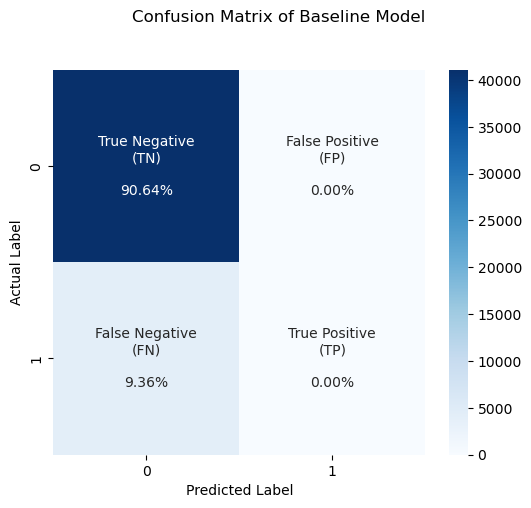

In [6]:
chart = 'Baseline Model'
cm = confusion_matrix(y_test_feng, y_test_pred)

plot_cm(cm, chart)

In [7]:
print(classification_report(y_true = y_test_feng, y_pred = y_test_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     41089
           1       0.00      0.00      0.00      4245

    accuracy                           0.91     45334
   macro avg       0.45      0.50      0.48     45334
weighted avg       0.82      0.91      0.86     45334



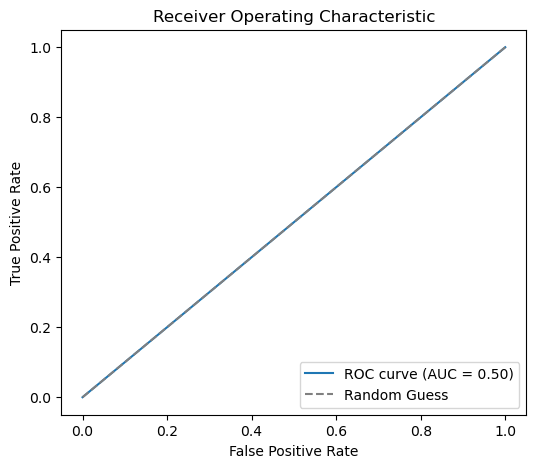

In [8]:
y_prob = base_model.predict_proba(X_test_feng)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_feng, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Based on this baseline model, a precision of 0.45 (using the macro avg as it takes into account the balanced model performance for all classes) and an ROC-AUC of 0.5 are the baseline metrics that will be referred to in the model evaluation.

## Modeling

In [9]:
ls_model = [DecisionTreeClassifier, RandomForestClassifier, XGBClassifier]

ls_train_data = {'WithoutResampling': (X_train_feng['WithoutResampling'], y_train_feng['WithoutResampling']),
                 'Undersampling' : (X_train_feng['Undersampling'], y_train_feng['Undersampling']), 
                 'Oversampling' : (X_train_feng['Oversampling'], y_train_feng['Oversampling']),
                 'SMOTE' : (X_train_feng['SMOTE'], y_train_feng['SMOTE'])}

In [10]:
df_result = pd.DataFrame(columns = ['resampling_method', 'model', 'train_f1_score', 'test_f1_score', 'train_time'])

for key, values in ls_train_data.items():
    for model in ls_model:
        
        model_ = model(random_state=config['ls_model']['random_state'][0])

        train_time_t0 = time.time()
        model_.fit(values[0], values[1])
        train_time_t1 = time.time()
        train_time = train_time_t1 - train_time_t0
        
        print(f"Model {model.__name__} with {key} resampling is done.")

        # f1 train
        y_train_pred = model_.predict(values[0])
        train_f1_score = f1_score(y_train_pred, values[1])
        
        # f1 test
        y_test_pred = model_.predict(X_test_feng)
        test_f1_score = f1_score(y_test_pred, y_test_feng)
        
        train_precision = precision_score(values[1], y_train_pred, zero_division=0)
        train_recall = recall_score(values[1], y_train_pred)
        train_accuracy = accuracy_score(values[1], y_train_pred)
        
        test_precision = precision_score(y_test_feng, y_test_pred, zero_division=0)
        test_recall = recall_score(y_test_feng, y_test_pred)
        test_accuracy = accuracy_score(y_test_feng, y_test_pred)
        
        ls_log = pd.DataFrame({'resampling_method': [key], 
                    'model': [model.__name__], 
                    'train_f1_score': [train_f1_score], 
                    'test_f1_score': [test_f1_score],
                    'train_precision': [train_precision],
                    'test_precision': [test_precision],
                    'train_recall': [train_recall],
                    'test_recall': [test_recall],
                    'train_accuracy': [train_accuracy],
                    'test_accuracy': [test_accuracy],
                    'train_time': [train_time]})
        df_result = df_result.dropna(axis=1, how='all')
        ls_log = ls_log.dropna(axis=1, how='all')

        df_result = pd.concat([df_result, ls_log], ignore_index=True)

df_result = df_result.sort_values('test_precision', ascending=False).reset_index().drop('index', axis = 1)
df_result

Model DecisionTreeClassifier with WithoutResampling resampling is done.
Model RandomForestClassifier with WithoutResampling resampling is done.
Model XGBClassifier with WithoutResampling resampling is done.
Model DecisionTreeClassifier with Undersampling resampling is done.
Model RandomForestClassifier with Undersampling resampling is done.
Model XGBClassifier with Undersampling resampling is done.
Model DecisionTreeClassifier with Oversampling resampling is done.
Model RandomForestClassifier with Oversampling resampling is done.
Model XGBClassifier with Oversampling resampling is done.
Model DecisionTreeClassifier with SMOTE resampling is done.
Model RandomForestClassifier with SMOTE resampling is done.
Model XGBClassifier with SMOTE resampling is done.


,resampling_method,model,train_f1_score,test_f1_score,train_precision,test_precision,train_recall,test_recall,train_accuracy,test_accuracy,train_time
0,WithoutResampling,XGBClassifier,0.110407,0.092178,0.867756,0.776119,0.058954,0.048999,0.911031,0.909626,0.284995
1,WithoutResampling,RandomForestClassifier,0.682131,0.528321,0.764183,0.587320,0.615990,0.480094,0.946236,0.919729,4.622676
2,WithoutResampling,DecisionTreeClassifier,0.675016,0.495399,0.778525,0.532809,0.595801,0.462898,0.946274,0.911700,0.181844
3,SMOTE,RandomForestClassifier,0.949839,0.485819,0.937257,0.420572,0.962763,0.575029,0.949156,0.886024,8.507245
4,SMOTE,DecisionTreeClassifier,0.949629,0.479545,0.941156,0.410894,0.958257,0.575736,0.949172,0.882980,0.309626
5,Oversampling,RandomForestClassifier,0.938614,0.411542,0.890732,0.312347,0.991937,0.603062,0.935127,0.838510,7.651362
6,Oversampling,DecisionTreeClassifier,0.938479,0.402227,0.892371,0.301446,0.989611,0.604240,0.935127,0.831826,0.310789
7,SMOTE,XGBClassifier,0.849936,0.357143,0.870656,0.280198,0.830180,0.492344,0.853424,0.834032,0.438754
8,Undersampling,RandomForestClassifier,0.941930,0.293494,0.941503,0.186805,0.942358,0.684335,0.941904,0.691490,1.261745
9,Oversampling,XGBClassifier,0.734101,0.283357,0.735975,0.185207,0.732237,0.602827,0.734777,0.714475,0.323102


In this case, precision is used as the evaluation metric, as the main focus of solving this problem is to ensure that transactions flagged as fraudulent are truly fraudulent and minimize legitimate transactions that are incorrectly flagged as fraudulent.

Although all models performed better than the baseline model, they were overfitted on the training data. Therefore, the models need hyperparameter tuning to improve performance.

Hyperparameter tuning is done by cross-validation (cv) process. In this tuning process, k-fold cross-validation is applied. The train data used is the dataset before preprocessing to avoid data leakage. 

## Cross-validation and Hyperparameter Tuning

In [11]:
X_train_path = '../' + config['train_test_data']['directory'] + config['train_test_data']['X_train']
X_train = joblib.load(X_train_path)

In [12]:
X_train.head()

,browser,source,age,sex,purchase_value
61049,Chrome,Ads,31,F,42
141787,Chrome,Ads,32,M,38
84407,Safari,SEO,36,M,12
115800,IE,SEO,19,M,12
61857,Chrome,SEO,28,F,41


In [13]:
cat_features = config['data_source']['cat_features']
num_features = config['data_source']['num_features']

cat_transformer = Pipeline(steps = [('Imputer_nan', SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='UNKNOWN')),
                                    ('Imputer_cat', SimpleImputer(missing_values='?', strategy='constant', fill_value='UNKNOWN')),
                                    ('OHE', OneHotEncoder(handle_unknown="ignore"))])

num_transformer = Pipeline(steps=[('Imputer', SimpleImputer(strategy='median'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features), 
        ('num', num_transformer, num_features)
    ]
)

In [14]:
ls_model = [DecisionTreeClassifier, RandomForestClassifier, XGBClassifier]

ls_params = {
    'dt': {
        'classifier__criterion': config['ls_model']['dt']['criterion'],
        'classifier__max_depth': config['ls_model']['dt']['max_depth'], 
        'classifier__class_weight': config['ls_model']['dt']['class_weight'],
        'classifier__random_state': config['ls_model']['random_state']
    },
    'rf': {
        'classifier__n_estimators': config['ls_model']['rf']['n_estimators'], 
        'classifier__max_depth': config['ls_model']['rf']['max_depth'], 
        'classifier__min_samples_split': config['ls_model']['rf']['min_samples_split'],
        'classifier__class_weight': config['ls_model']['rf']['class_weight'],
        'classifier__random_state': config['ls_model']['random_state']
    },
    'xgb': {
        'classifier__n_estimators': config['ls_model']['xgb']['n_estimators'], 
        'classifier__learning_rate': config['ls_model']['xgb']['learning_rate'], 
        'classifier__max_depth': config['ls_model']['xgb']['max_depth'],
        'classifier__subsample': config['ls_model']['xgb']['subsample'],
        'classifier__random_state': config['ls_model']['random_state']
    },
}

ls_sampler = [None, RandomUnderSampler, RandomOverSampler, SMOTE]

In [15]:
precision = make_scorer(precision_score, average='weighted')
ls_cv_result = []

for model, params in zip(ls_model, ls_params):
    for sampler in ls_sampler:
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model())])
        
        clf = GridSearchCV(estimator = pipeline, param_grid = ls_params[params], cv = 5, scoring = precision, return_train_score = True)
        clf.fit(X_train, y_train_feng['WithoutResampling'])
        
        print(f"Model {model.__name__} with sampler {sampler.__name__ if sampler else 'WithoutResampling'} is done.")
        
        cv_results = pd.DataFrame(clf.cv_results_)
        cv_results = pd.DataFrame(clf.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'mean_fit_time']]
        cv_results = cv_results.rename(columns = {'mean_train_score': 'train_precision',
                                                  'mean_test_score': 'test_precision',
                                                  'mean_fit_time': 'train_time'})
        cv_results['model'] = model.__name__
        cv_results['resampling_method'] = sampler.__name__ if sampler != None else 'WithoutResampling'
        
        ls_cv_result.append(cv_results)
        
train_log = pd.concat(ls_cv_result, ignore_index=True)
train_log = train_log[['resampling_method', 'model', 'params', 'train_precision', 'test_precision', 'train_time']]
train_log = train_log.sort_values('test_precision', ascending = False).reset_index().drop(['index'], axis = 1)
train_log

Model DecisionTreeClassifier with sampler WithoutResampling is done.
Model DecisionTreeClassifier with sampler RandomUnderSampler is done.
Model DecisionTreeClassifier with sampler RandomOverSampler is done.
Model DecisionTreeClassifier with sampler SMOTE is done.
Model RandomForestClassifier with sampler WithoutResampling is done.
Model RandomForestClassifier with sampler RandomUnderSampler is done.
Model RandomForestClassifier with sampler RandomOverSampler is done.
Model RandomForestClassifier with sampler SMOTE is done.
Model XGBClassifier with sampler WithoutResampling is done.
Model XGBClassifier with sampler RandomUnderSampler is done.
Model XGBClassifier with sampler RandomOverSampler is done.
Model XGBClassifier with sampler SMOTE is done.


,resampling_method,model,params,train_precision,test_precision,train_time
0,WithoutResampling,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.910790,0.908454,0.198950
1,SMOTE,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.910790,0.908454,0.186886
2,RandomUnderSampler,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.910790,0.908454,0.182457
3,RandomOverSampler,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.910790,0.908454,0.176297
4,WithoutResampling,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.910497,0.902853,0.252676
...,...,...,...,...,...,...
139,RandomUnderSampler,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.837679,0.835615,0.542282
140,RandomUnderSampler,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.837679,0.835615,0.550266
141,SMOTE,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.837679,0.835615,0.541609
142,RandomOverSampler,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.837679,0.835615,0.540097


In [16]:
best_model = train_log.iloc[train_log[['resampling_method', 'model', 'test_precision']].groupby(['resampling_method', 'model']).idxmax()\
                            .loc[:,'test_precision']]\
                            .sort_values('test_precision', ascending = False)\
                            .reset_index()\
                            .drop(['index'], axis = 1)
best_model

,resampling_method,model,params,train_precision,test_precision,train_time
0,RandomOverSampler,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.910790,0.908454,0.176297
1,RandomUnderSampler,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.910790,0.908454,0.182457
2,SMOTE,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.910790,0.908454,0.186886
3,WithoutResampling,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.910790,0.908454,0.198950
4,RandomOverSampler,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.951303,0.894301,0.218599
5,RandomUnderSampler,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.951303,0.894301,0.217278
6,SMOTE,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.951303,0.894301,0.214755
7,WithoutResampling,DecisionTreeClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.951303,0.894301,0.217242
8,RandomOverSampler,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.851849,0.846868,2.848111
9,RandomUnderSampler,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...",0.851849,0.846868,2.903198


Above are the best hyperparameters for each model and sampling method. With these hyperparameters, all models will be evaluated to determine the best model using the test dataset.

## Evaluation Model

In [17]:
columns = ['resampling_method', 'model', 'params', 'train_precision', 'test_precision', 'train_time']
ls_eval_result = []

for model in ls_model:
    for sampler in ls_sampler:
        i = best_model[best_model['model'] == model.__name__].index.values[0]
        
        param = {key[12:]:value for (key, value) in best_model.iloc[i].params.items()}
        clf = model(**param)
        
        if sampler == None:
            resampling_method = 'WithoutResampling'
            X_train_eval = X_train_feng['WithoutResampling']
            y_train_eval = y_train_feng['WithoutResampling']

        elif sampler == RandomUnderSampler:
            resampling_method = RandomUnderSampler.__name__
            X_train_eval = X_train_feng['Undersampling']
            y_train_eval = y_train_feng['Undersampling']

        elif sampler == RandomOverSampler:
            resampling_method = RandomOverSampler.__name__
            X_train_eval = X_train_feng['Oversampling']
            y_train_eval = y_train_feng['Oversampling']
            
        elif sampler == SMOTE:
            resampling_method = RandomOverSampler.__name__
            X_train_eval = X_train_feng['SMOTE']
            y_train_eval = y_train_feng['SMOTE']

        else:
            assert ValueError(f"There's no {best_model.iloc[i]['resampling_method']} resampling method in the list")
        
        train_time_t0 = time.time()
        clf.fit(X_train_eval, y_train_eval)
        train_time_t1 = time.time()
        train_time = train_time_t1 - train_time_t0
        
        y_train_pred = clf.predict(X_train_feng['WithoutResampling'])
        y_test_pred = clf.predict(X_test_feng)

        score = {'resampling_method' : [resampling_method],
                 'model': [best_model.iloc[i]['model']],
                 'params': [param],
                 'train_precision': [precision_score(y_train_feng['WithoutResampling'], y_train_pred)],
                 'test_precision': [precision_score(y_test_feng, y_test_pred)],
                 'train_time': [train_time]
                }
        ls_eval_result.append(pd.DataFrame(score, columns = columns))


evaluation_metrics = pd.concat(ls_eval_result, ignore_index = True)
evaluation_metrics = evaluation_metrics.sort_values(['test_precision'], ascending=False).reset_index().drop(['index'], axis = 1)
evaluation_metrics

,resampling_method,model,params,train_precision,test_precision,train_time
0,WithoutResampling,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.944954,0.783784,0.163610
1,RandomOverSampler,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gin...",0.568237,0.409624,0.316793
2,RandomOverSampler,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gin...",0.459897,0.301634,0.327364
3,WithoutResampling,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gin...",0.447601,0.293855,0.200040
4,RandomOverSampler,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.214091,0.193991,0.223632
5,RandomUnderSampler,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gin...",0.236262,0.174643,0.040827
6,RandomOverSampler,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.162977,0.143917,0.219813
7,RandomUnderSampler,XGBClassifier,"{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",0.153364,0.139815,0.055156
8,WithoutResampling,RandomForestClassifier,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.128596,0.122343,3.444995
9,RandomOverSampler,RandomForestClassifier,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.129547,0.122051,6.271720


The table above shows that the DecisionTreeClassifier model has the highest performance based on precision. Thus, DecisionTreeClassifier is the final model chosen for this problem.

In [48]:
evaluation_metrics['params'][0]

{'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 50,
 'random_state': 42,
 'subsample': 0.8}

In [49]:
i = best_model[best_model['model'] == DecisionTreeClassifier.__name__].index.values[0]

param = {key[12:]:value for (key, value) in best_model.iloc[i].params.items()}

X = X_train_feng['WithoutResampling'] if best_model.iloc[i].resampling_method == 'WithoutResampling' \
    else X_train_feng['Undersampling'] if best_model.iloc[i].resampling_method == 'RandomUnderSampler' \
    else X_train_feng['Oversampling'] if best_model.iloc[i].resampling_method == 'RandomOverSampler' \
    else X_train_feng['SMOTE']
y = y_train_feng['WithoutResampling'] if best_model.iloc[i].resampling_method == 'WithoutResampling' \
    else y_train_feng['Undersampling'] if best_model.iloc[i].resampling_method == 'RandomUnderSampler' \
    else y_train_feng['Oversampling'] if best_model.iloc[i].resampling_method == 'RandomOverSampler' \
    else y_train_feng['SMOTE']

final_model = DecisionTreeClassifier(**param)
final_model.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', max_depth=30, random_state=42)

In [50]:
model_path = '../' + config['final_model']['model_directory'] + config['final_model']['model_name']

joblib.dump(final_model, model_path)

['../models/Decision_Tree_Classifier.pkl']

In [51]:
y_test_pred = final_model.predict(X_test_feng)

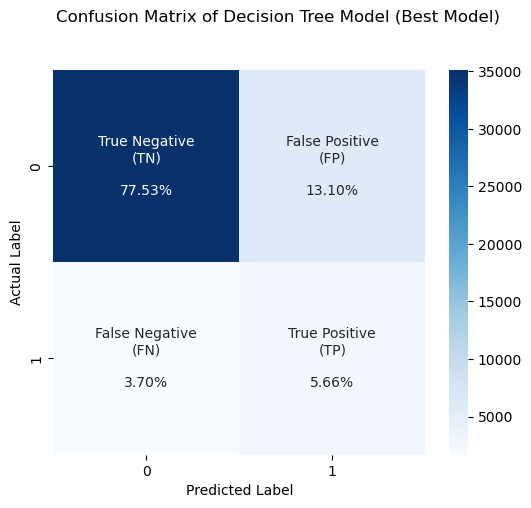

In [52]:
chart = 'Decision Tree Model (Best Model)'
cm = confusion_matrix(y_test_feng, y_test_pred)

plot_cm(cm, chart)

In [53]:
print(classification_report(y_true = y_test_feng,
                            y_pred = y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90     41089
           1       0.30      0.60      0.40      4245

    accuracy                           0.83     45334
   macro avg       0.63      0.73      0.65     45334
weighted avg       0.89      0.83      0.86     45334



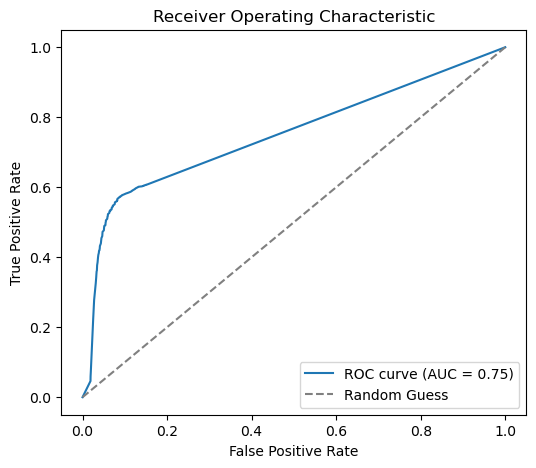

In [54]:
y_prob = final_model.predict_proba(X_test_feng)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_feng, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Compared to the baseline model, the final model performs better with a precision of 0.63 and ROC-AUC of 0.75. Thus, the model is good enough to classify whether a transaction in e-commerce is fraud or not.